## Using A Pre-trained Convnet

Follows on from previous notebook on the classification of flower images.  In this notebook use a pre-trained network.

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. 

For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

Will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet. 


This work references the following sources:
- `http://blog.udacity.com/2018/10/introducing-the-pytorch-scholarship-challenge-from-facebook.html`
- `http://machinelearningmastery.com/crash-course-convolutional-neural-networks/`
- `http://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720`
- `http://www.manning.com/books/deep-learning-with-python`
- `https://github.com/spmallick/learnopencv/blob/master/Keras-Transfer-Learning/transfer-learning-vgg.ipynb`

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. 
These features are then run through a new classifier, which is trained from scratch.

Convnets used for image classification comprise two parts: they start with a series of pooling and convolution 
layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of 
convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data 
through it, and training a new classifier on top of the output.

In [1]:
import os, shutil
import numpy as np
from IPython.display import display, Image
import PIL
from glob import glob
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator, load_img

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
%matplotlib inline
from keras import models
from keras import layers
from keras import optimizers

C:\Users\richard\Anaconda3\envs\tf15\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Set up the folders and import data

In [108]:
images = [PIL.Image.open(f) for f in glob('D:\\ml_code\\keras\\images\\*gif')];

def img2array(im):
    if im.mode != 'RGB':
        im = im.convert(mode='RGB');
    return np.frombuffer(im.tobytes(),dtype='uint8').reshape((im.size[1],im.size[0],3));

np_images = [img2array(im) for im in images];

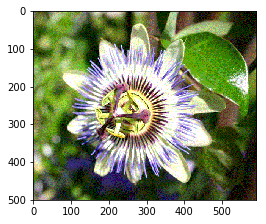

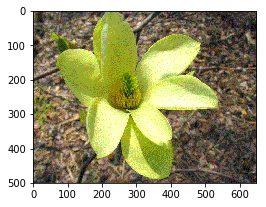

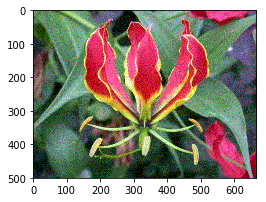

In [109]:
for img in np_images:
    plt.figure(figsize=[4,4])
    plt.imshow(img);
 

The flower images vary greatly in features across 102 classes.  Each class is in a seperate folder and it appears there are an uneven number of samples per class.  Lets amalgamate the iamges into one folder for analysis 

In [110]:
#locations of src and dest directories
train_dir = 'D:\\ml_code\\keras\\flower_data\\train\\'
test_dir = 'D:\\ml_code\\keras\\flower_data\\test\\'
total_train = 'D:\\ml_code\\keras\\flower_data\\total_train'
total_test = 'D:\\ml_code\\keras\\flower_data\\total_test'

In [111]:
def make_csv(file):
    with open(file,'w') as file:
        for dirname, subdirlist,filelist in os.walk(train_dir):
                line = dirname.split("\\")
                for fname in filelist:
                    res = fname + "\t" + line[-1]
                    file.write(res)
                    file.write("\n")

#file = 'data\\flower_data.csv'
#make_csv(file)                    

#make a csv file for current and future reference
df = pd.read_csv('csv_flowers.csv',delimiter = '\t',names = ["Image","Id"])
df.head()

,Image,Id
0,image_06734.jpg,1
1,image_06735.jpg,1
2,image_06736.jpg,1
3,image_06737.jpg,1
4,image_06738.jpg,1


In [6]:
#get the frequency of the classes
print("Label Frequency" )
print(df["Id"].value_counts()[::4])

Label Frequency
51    206
73    147
88    116
43    100
37     92
76     83
50     73
96     72
98     68
18     65
30     61
48     57
5      54
87     51
99     50
85     48
22     47
4      44
63     42
15     38
27     36
3      36
6      35
25     34
26     33
34     28
Name: Id, dtype: int64


An example of an unbalanced class 

Keras has a `class_weight` argument in method `model.fit` to handle imbalanced data. The keys of the `class_weights` dictionary should reflect the order in the classes_ attribute of the encoder. 
- `https://stackoverflow.com/questions/43481490/keras-class-weights-class-weight-for-one-hot-encoding`

In [112]:
y = np.array((df['Id']))

#one hot encode the integers
# Instantiate the label encoder
le = LabelEncoder()

# Fit the label encoder to our label series
le.fit(list(y))

# Create integer based labels Series
y_integers = le.transform(list(y))

#print(y_integers)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)

d_class_weights = dict(enumerate(class_weights))

In [113]:
#sort the weights for viewing
sorted_by_value = sorted(d_class_weights.items(), key=lambda kv: kv[1])
sorted_by_value[::5]

[(50, 0.3118218161050828),
 (73, 0.4523612261806131),
 (82, 0.6176470588235294),
 (36, 0.6982097186700768),
 (75, 0.7739192062367115),
 (43, 0.8799355358581789),
 (52, 0.9176470588235294),
 (89, 0.9732620320855615),
 (29, 1.0530376084860174),
 (54, 1.1470588235294117),
 (96, 1.1895424836601307),
 (56, 1.2847058823529411),
 (30, 1.338235294117647),
 (53, 1.3667083854818523),
 (37, 1.4598930481283423),
 (9, 1.6904024767801857),
 (2, 1.7843137254901962),
 (66, 1.7843137254901962),
 (20, 1.8892733564013842),
 (25, 1.946524064171123),
 (33, 2.2941176470588234)]

## Get the Model

In [9]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet.
* `input_shape`, the shape of the image tensors that we will feed to the network.

Detail of the architecture of the VGG16 convolutional base:

In [10]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed: 

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a 
standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and 
cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the 
most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at 
all.
* Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This 
allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. 
However, for this same reason, this technique is far more expensive than the first one.

Try first option as second option can be very expensive in processing time

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as 
their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

In [11]:
#count the number of folders (classes) of flowers
base_dir = "D:\\ml_code\\keras\\flower_data\\train\\"
num_classes = 0
for folder in os.listdir(base_dir):
    num_classes+=1
    
train_dir = "D:\\ml_code\\keras\\flower_data\\train"
validation_dir = "D:\\ml_code\\keras\\flower_data\\valid\\"
#test_dir = "D:\\ml_code\\keras\\flower_data\\test\\"

train_count = sum([len(files) for r, d, files in os.walk(train_dir)])
valid_count = sum([len(files) for r, d, files in os.walk(validation_dir)])
#test_count = sum([len(files) for r, d, files in os.walk(test_dir)])

print(train_count,valid_count)

6552 818


In [116]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
SIZE = 150

train_features = np.zeros(shape=(train_count, 4, 4, 512))
train_labels = np.zeros(shape=(train_count,num_classes))

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = conv_base.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= train_count:
        break
 
#flatten the images
train_features = np.reshape(train_features, (train_count, 4 * 4 * 512))

Found 6552 images belonging to 102 classes.


In [13]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
SIZE = 150

validation_features = np.zeros(shape=(valid_count, 4, 4, 512))
validation_labels = np.zeros(shape=(valid_count,num_classes))

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = conv_base.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= valid_count:
        break
        
validation_features = np.reshape(validation_features, (valid_count, 4 * 4 * 512))

Found 818 images belonging to 102 classes.


In [14]:
print(validation_features.shape)
print(validation_labels.shape)

(818, 8192)
(818, 102)


Used reshape above as the data is in the format `(samples, 4, 4, 512)`. Because they are to be fed into a densely-connected classifier, first flatten them to `(samples, 8192)`:

Define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and 
labels that we just recorded:

In [21]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 6552 samples, validate on 818 samples
Epoch 1/30
6552/6552 [==============================] - 3s 517us/step - loss: 4.4266 - acc: 0.0658 - val_loss: 4.1722 - val_acc: 0.1296
Epoch 2/30
6552/6552 [==============================] - 4s 549us/step - loss: 3.9514 - acc: 0.1755 - val_loss: 3.7383 - val_acc: 0.2592
Epoch 3/30
6552/6552 [==============================] - 4s 603us/step - loss: 3.5098 - acc: 0.2677 - val_loss: 3.3512 - val_acc: 0.3044
Epoch 4/30
6552/6552 [==============================] - 4s 645us/step - loss: 3.1470 - acc: 0.3356 - val_loss: 3.0258 - val_acc: 0.3888
Epoch 5/30
6552/6552 [==============================] - 4s 586us/step - loss: 2.8253 - acc: 0.4049 - val_loss: 2.7485 - val_acc: 0.4462
Epoch 6/30
6552/6552 [==============================] - 4s 570us/step - loss: 2.5449 - acc: 0.4599 - val_loss: 2.5194 - val_acc: 0.4939
Epoch 7/30
6552/6552 [==============================] - 4s 617us/step - loss: 2.3225 - acc: 0.5005 - val_loss: 2.3334 - val_acc: 0.5281
E

Training is very fast, since we only have to deal with two `Dense` layers.  The results are much higher than prvious notebook where we defined our own convolutional model first.

Loss and accuracy curves during training:

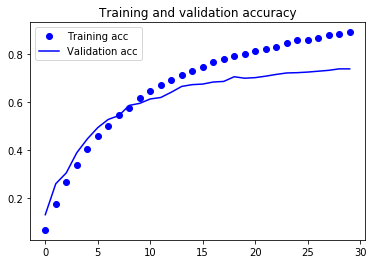

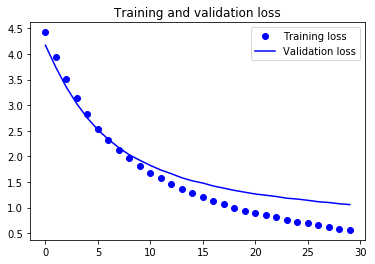

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We reach a validation accuracy of about 70%, much better than what we could achieve in the previous section with our small model trained from 
scratch. Plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. 
This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.

In [106]:
#get predictions from model
pred = model.predict(validation_features)

#get the class from max 
pred_class = np.argmax(pred,axis=1)

#get the labels
labels = validation_generator.class_indices

#map predicted labels with unique ids
labels = dict((v,k) for k,v in labels.items())
predictions = np.array(([int(labels[k]) for k in pred_class]))

ground_truth=validation_generator.classes

errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),valid_count))

No of errors = 809/818


We have a very high number of errors, this completely disagrees with the validation curves.  